## Import Data from Database

In [8]:
import os
import psycopg2
import pandas as pd

host = 'localhost'
database = 'dsa3101' # default db name
user = 'postgres'
post_pwd = os.environ["POSTGRES_PASSWORD"]
post_port = 5434


def create_df():
    try:
        conn = psycopg2.connect(
            host=host,
            user=user,
            password=post_pwd,
            port=post_port,
            database=database)
        query = "SELECT * FROM RATINGS AS R LEFT JOIN PRODUCTS AS P ON  R.PRODUCT_ID = P.PRODUCT_ID "
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=conn)
        return df
    except Exception as e:
        print("An error occurred:", e)
        conn.rollback()  # Rollback in case of error
    finally:
        conn.close()  # Close the connection
# Display the DataFrame
product_ratings_df = create_df()


/var/folders/73/fb491fb94kj3nr6_byql8qdh0000gn/T/ipykernel_29715/2951402558.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


## Read in Data

In [10]:
import pandas as pd
product_ratings_df.rename(columns={
    'review_title': 'short_reviews',
    'review_content': 'long_reviews'
}, inplace=True)
product_ratings_df

,product_id,average_rating,short_reviews,long_reviews,rating_count,product_id,product_name,about_product,category,actual_price,discounted_price,discount_percentage
0,B002PD61Y4,4.1,"good tool to use for,Brand is always good,Over...",good quality tool from d linkWiFi signal is go...,16262,B002PD61Y4,D-Link DWA-131 300 Mbps Wireless Nano USB Adap...,Connects your computer to a high-speed wireles...,Computers&Accessories|NetworkingDevices|Networ...,14.50,6.08,0.58
1,B002SZEOLG,4.2,Works on linux for me. Get the model with ante...,I use this to connect an old PC to internet. I...,179692,B002SZEOLG,TP-Link Nano USB WiFi Dongle 150Mbps High Gain...,150 Mbps Wi-Fi —— Exceptional wireless speed u...,Computers&Accessories|NetworkingDevices|Networ...,16.07,8.99,0.44
2,B003B00484,4.3,"Works Good,Perfect replacement cell for trimme...","Works good,Bought it to replace my Phillips QT...",27201,B003B00484,Duracell Plus AAA Rechargeable Batteries (750 ...,Duracell Rechargeable AAA 750mAh batteries sta...,Electronics|GeneralPurposeBatteries&BatteryCha...,5.99,4.79,0.20
3,B003L62T7W,4.3,"Handy Mouse,Good quality mouse,Good one.,Good,...","Liked this Product,https://m.media-amazon.com/...",31534,B003L62T7W,"Logitech B100 Wired USB Mouse, 3 yr Warranty, ...","A comfortable, ambidextrous shape feels good i...",Computers&Accessories|Accessories&Peripherals|...,4.50,3.35,0.26
4,B004IO5BMQ,4.5,"Good silent mouse,Too small to hold!,Reviewing...",It's little small for big hands. But best avai...,54405,B004IO5BMQ,"Logitech M235 Wireless Mouse, 1000 DPI Optical...",You can surf the Web with more comfort and eas...,Computers&Accessories|Accessories&Peripherals|...,11.94,8.39,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,B0BPCJM7TB,4.0,"Nice frother,Nice product I like this product,...",This is my first coffee frother and I just lov...,43,B0BPCJM7TB,WIDEWINGS Electric Handheld Milk Wand Mixer Fr...,The battery operated milk frother is easy to c...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,11.99,3.11,0.74
1347,B0BPJBTB3F,2.0,"Bad quality,Amazing product..",The heating capacity is zero .Moreover i have ...,2,B0BPJBTB3F,Khaitan ORFin Fan heater for Home and kitchen-...,Khaitan Orfin Fan heater for Home and kitchen|...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",29.94,15.59,0.48
1348,B0BQ3K23Y1,4.8,"Oratech Best Coffee Frother,Great,My review ab...","Overall, I love this Oratech Coffee frother an...",28,B0BQ3K23Y1,"Oratech Coffee Frother electric, milk frother ...",-Make delicious milk foam creamer for your dri...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,5.99,3.35,0.44
1349,B0BQRJ3C47,5.0,Awesome Product,Quick delivery.Awesome ProductPacking was good...,0,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",💎[The Fastest Charge] - This iPhone USB C cabl...,Computers&Accessories|Accessories&Peripherals|...,11.99,2.99,0.75


# EDA

In [208]:
#split product categories into its base_category
product_ratings_df["base_category"] = product_ratings_df["category"].str.split("|").str[0]


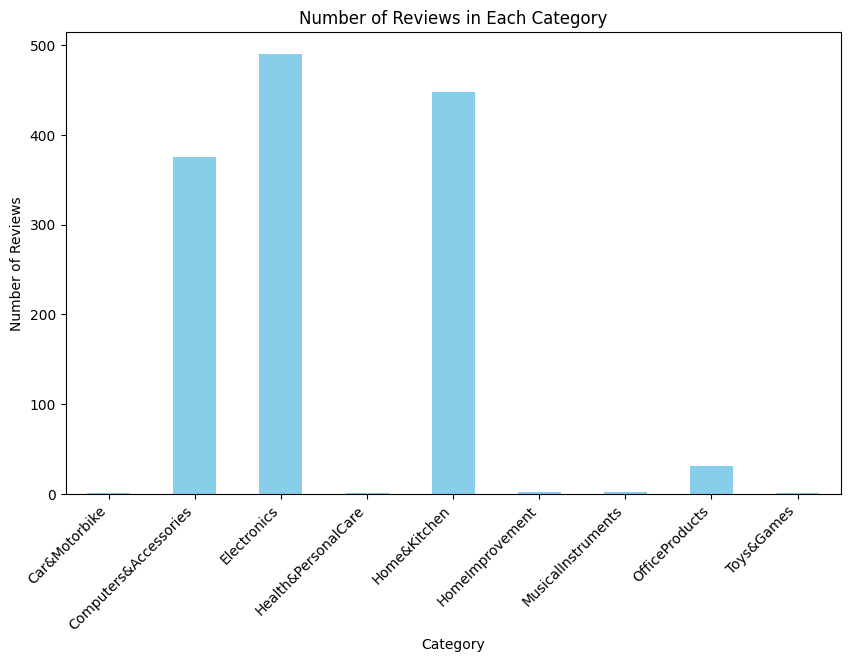

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
# Group by category and count the number of reviews in each
category_counts = product_ratings_df.groupby('base_category')['average_rating'].count()

# Plot the result
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right') 
plt.show()


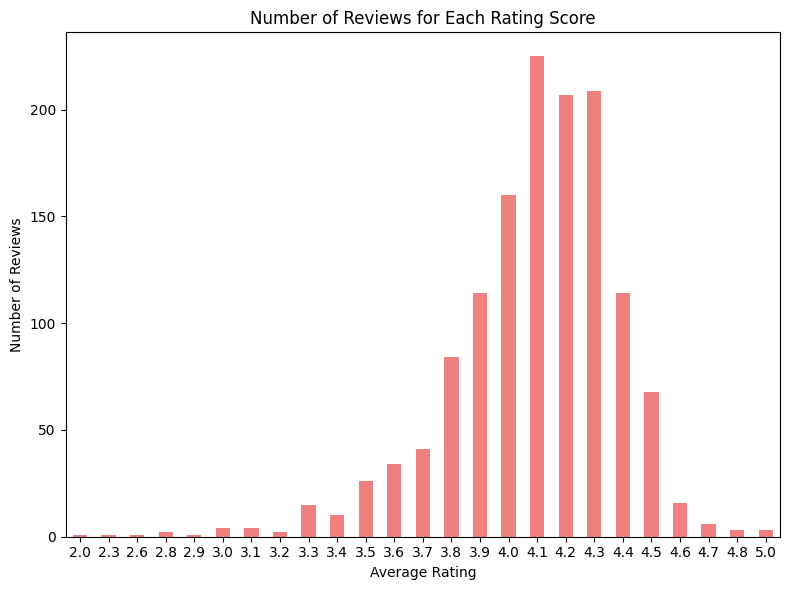

In [204]:
# Group by average rating and count the number of reviews for each rating
rating_counts = product_ratings_df.groupby('average_rating').size()

# Plot the result
plt.figure(figsize=(8,6))
rating_counts.plot(kind='bar', color='lightcoral')
plt.title('Number of Reviews for Each Rating Score')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
plt.tight_layout()
plt.show()


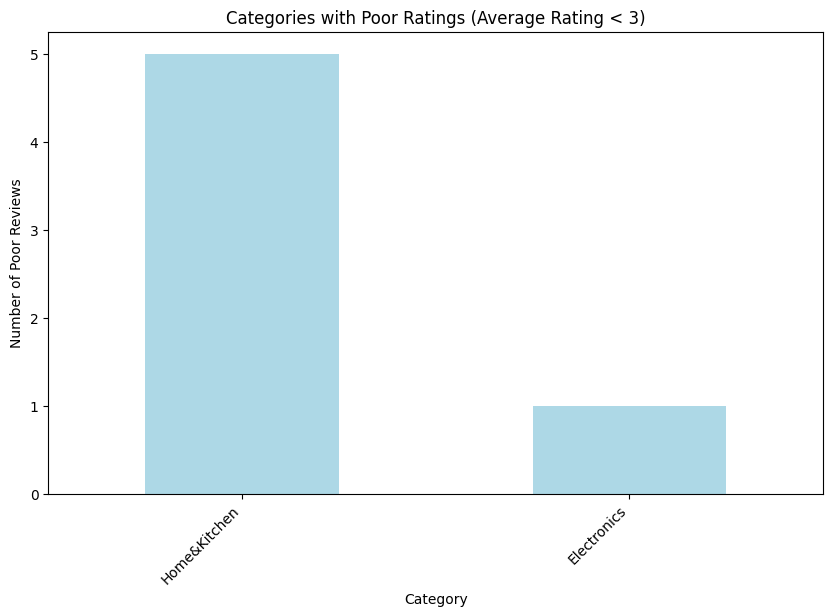

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'product_ratings_df' and has 'average_rating' and 'category' columns

# Define a threshold for poorly rated products (e.g., average rating less than 3)
poorly_rated_df = product_ratings_df[product_ratings_df['average_rating'] < 3]

# Group by category and count the number of poorly rated reviews for each category
poorly_rated_counts = poorly_rated_df.groupby('base_category').size()

# Sort the counts to make the plot more readable
poorly_rated_counts = poorly_rated_counts.sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10,6))
poorly_rated_counts.plot(kind='bar', color='lightblue')
plt.title('Categories with Poor Ratings (Average Rating < 3)')
plt.xlabel('Category')
plt.ylabel('Number of Poor Reviews')
plt.xticks(rotation=45, ha='right') 
plt.show()

# Sentiment Analysis

### Vader Analysis

In [2]:
import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

### `short_reviews` and `long_reviews` columns are a `str` of mutliple reviews

e.g "Works Good, Perfect replacement cell for trimmer,Wow,As they said in ad worth it,A good product,Fit for phillips trimmer.,Good,Good Product"

In [275]:
def get_vader_score(text:str):
    indiv_reviews = text.split(",") #split str into list of individual strs
    vader_scores = [analyzer.polarity_scores(text).get("compound") for text in indiv_reviews] # apply vader analysis to each reviews
    avg_vader_scores = sum(vader_scores)/len(vader_scores) # get avg vader scores over all reviews
    return avg_vader_scores


product_ratings_df['long_reviews_vader_analysis'] = product_ratings_df['long_reviews'].apply(get_vader_score)
product_ratings_df['short_reviews_vader_analysis'] = product_ratings_df['short_reviews'].apply(get_vader_score)


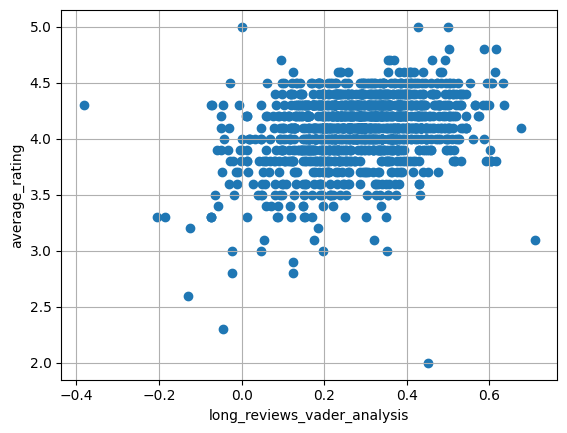

In [276]:
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(product_ratings_df['long_reviews_vader_analysis'], product_ratings_df['average_rating'])
plt.xlabel('long_reviews_vader_analysis')
plt.ylabel('average_rating')
plt.grid(True)
plt.show()

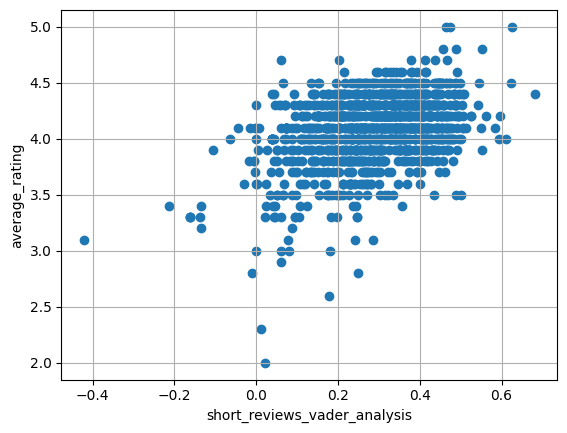

In [277]:
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(product_ratings_df['short_reviews_vader_analysis'], product_ratings_df['average_rating'])
plt.xlabel('short_reviews_vader_analysis')
plt.ylabel('average_rating')
plt.grid(True)
plt.show()

### Outliers

In [282]:
filtered_df = product_ratings_df[(product_ratings_df['long_reviews_vader_analysis'] < -0.2) & (product_ratings_df['average_rating'] > 4)]
filtered_df

,product_id,average_rating,short_reviews,long_reviews,rating_count,product_id.1,product_name,about_product,category,actual_price,discounted_price,discount_percentage,base_category,clean_short_reviews,clean_long_reviews,long_reviews_vader_analysis,short_reviews_vader_analysis
1107,B09XJ1LM7R,4.3,do not buy,"tv on off not working, so difficult to battery...",12,B09XJ1LM7R,7SEVEN® Compatible for Tata Sky Remote Origina...,[Compatible] All model of dth SD / HD / HD+ Pl...,"Electronics|HomeTheater,TV&Video|Accessories|R...",9.59,4.79,0.5,Electronics,not buy,not difficult battery really bad product,-0.382,0.0


# Identifying Common Issues

## Text Cleaning

In [283]:
from nltk.corpus import stopwords, words
from nltk.stem.wordnet import WordNetLemmatizer
import string
import contractions
import re

stop = set(stopwords.words('english'))

stop.remove("not") #exclude "not" from stopwords as goal of TF-IDF is to identify words that are informative for distinguishing between different documents or classes
english_words = set(words.words())
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    #remove contractions
    cont_free = contractions.fix(doc)

    #remove hyperlinks
    URL_PATTERN = r'https?://\S+|www\.\S+'
    # Substitute URLs with an empty string
    url_free = re.sub(URL_PATTERN, '', cont_free)

    #remove emojis
    # emoji_pattern = re.compile("["
    #     u"U0001F600-U0001F64F"  # emoticons
    #     u"U0001F300-U0001F5FF"  # symbols & pictographs
    #     u"U0001F680-U0001F6FF"  # transport & map symbols
    #     u"U0001F1E0-U0001F1FF"  # flags (iOS)
    #     u"U00002702-U000027B0"
    #     u"U000024C2-U0001F251"
    #     "]+", flags=re.UNICODE)
    # emo_free = emoji_pattern.sub(r'', url_free)

    #remove stop words
    stop_free = " ".join([i for i in url_free.lower().split() if i not in stop])
    non_eng_free = " ".join([i for i in stop_free.lower().split() if i in english_words])

    punc_free = ''.join(ch for ch in non_eng_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())


    return normalized


product_ratings_df["clean_short_reviews"] = product_ratings_df["short_reviews"].apply(clean)
product_ratings_df["clean_long_reviews"] = product_ratings_df["long_reviews"].apply(clean)

In [284]:
## Collate all individual bad long reviews with vader analysis < -0.25
DOCS_BAD_LONG_REVIEWS = []
BAD_LONG_REVIEWS = []

all_long_reviews = list(product_ratings_df["long_reviews"])

for reviews in all_long_reviews:
    indiv_reviews = reviews.split(",") #split str into list of individual strs
    for review in indiv_reviews:
        vader_score = analyzer.polarity_scores(review).get("compound") # apply vader analysis to each reviews
        if vader_score < -0.25:
            # print(review , vader_score)
            BAD_LONG_REVIEWS.append(clean(review))
            DOCS_BAD_LONG_REVIEWS.append(clean(review).split())



## Collate all individual bad short reviews with vader analysis < -0.25
DOCS_BAD_SHORT_REVIEWS = []
BAD_SHORT_REVIEWS = []

all_short_reviews = list(product_ratings_df["short_reviews"])

for reviews in all_short_reviews:
    indiv_reviews = reviews.split(",") #split str into list of individual strs
    for review in indiv_reviews:
        vader_score = analyzer.polarity_scores(review).get("compound") # apply vader analysis to each reviews
        if vader_score < -0.3:
            BAD_SHORT_REVIEWS.append(clean(review))
            DOCS_BAD_SHORT_REVIEWS.append(clean(review).split())


In [285]:
from collections import Counter
import matplotlib.pyplot as plt
# import wordcloud


def create_ngrams(token_list, nb_elements):

    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)

def frequent_words(list_words, ngrams_number=2, number_top_words=10):
    """
    Create n-grams for list of tokens

    Parameters
    ———-
    ngrams_number : int
    number_top_words : int
    output dataframe length

    Returns
    ——-
    DataFrame
    Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


### N-grams for bad short reviews

In [287]:
from itertools import chain
import pprint
unlist_docs_short_reviews = list(chain.from_iterable(DOCS_BAD_SHORT_REVIEWS))
print(" ## FREQUENT WORDS FROM BAD SHORT REVIEWS")
print("\n")
print("2-gram")
pprint.pprint(frequent_words(unlist_docs_short_reviews, ngrams_number=2))
print("\n")
print("3-gram")
pprint.pprint(frequent_words(unlist_docs_short_reviews, ngrams_number=3))


 ## FREQUENT WORDS FROM BAD SHORT REVIEWS


2-gram
[('not good', 70),
 ('good not', 31),
 ('product not', 17),
 ('quality not', 14),
 ('poor quality', 13),
 ('not best', 11),
 ('not support', 11),
 ('dull physical', 10),
 ('not excellent', 9),
 ('waste money', 9)]


3-gram
[('not good not', 15),
 ('good not excellent', 9),
 ('quality not good', 9),
 ('not excellent budget', 8),
 ('product not good', 6),
 ('dull physical dull', 6),
 ('physical dull physical', 6),
 ('good not best', 5),
 ('good price o', 5),
 ('good not good', 4)]


### N-grams for bad long reviews

In [288]:
unlist_docs_long_reviews = list(chain.from_iterable(DOCS_BAD_LONG_REVIEWS))
print(" ## FREQUENT WORDS FROM BAD LONG REVIEWS")
print("\n")
print("2-gram")
pprint.pprint(frequent_words(unlist_docs_long_reviews, ngrams_number=2))
print("\n\n")
print("3-gram")
pprint.pprint(frequent_words(unlist_docs_long_reviews, ngrams_number=3))

 ## FREQUENT WORDS FROM BAD LONG REVIEWS


2-gram
[('not good', 121),
 ('quality not', 38),
 ('product not', 29),
 ('not support', 27),
 ('also not', 26),
 ('sound quality', 25),
 ('battery life', 22),
 ('not great', 21),
 ('not working', 21),
 ('not like', 21)]



3-gram
[('quality not good', 18),
 ('battery life not', 10),
 ('even mentally prepared', 8),
 ('mentally prepared bad', 8),
 ('prepared bad camera', 8),
 ('bad camera little', 8),
 ('camera little could', 8),
 ('little could heating', 8),
 ('could heating got', 8),
 ('heating got even', 8)]


In [289]:
from sklearn.feature_extraction.text import CountVectorizer

# Example to extract bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(BAD_LONG_REVIEWS)  # 'reviews' is your list of review texts
ngrams = vectorizer.get_feature_names_out()

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(BAD_LONG_REVIEWS)
tfidf_scores = tfidf_matrix.toarray()
terms = tfidf_vectorizer.get_feature_names_out()

import numpy as np

# Mean TF-IDF score for each term
mean_scores = np.mean(tfidf_scores, axis=0)
top_ngrams = sorted(zip(mean_scores, terms), reverse=True)  # Highest scores first

# Display top 10 highest and lowest TF-IDF n-grams
top_10_highest = top_ngrams[:10]
top_10_lowest = top_ngrams[-10:]

print("Top 10 Highest TF-IDF N-grams:")
for score, term in top_10_highest:
    print(f"{term}: {score}")




Top 10 Highest TF-IDF N-grams:
good: 0.024982905444993476
product: 0.01836226103342128
quality: 0.01645735438331104
problem: 0.01429016467060558
bad: 0.013138909993852735
battery: 0.010586096635815083
use: 0.01047759687890226
time: 0.009618866120748984
cable: 0.00914695068628631
low: 0.00856068313506087


In [290]:
def display_reviews_with_keyword(reviews, keyword):
    """Display reviews containing a specific keyword."""
    print(f"Reviews containing the keyword '{keyword}':\n")
    matched_reviews = [review for review in reviews if keyword in review.lower()]
    
    if not matched_reviews:
        print(f"No reviews found containing the keyword '{keyword}'.")
    else:
        for i, review in enumerate(matched_reviews, 1):
            print(f"{i}. {review}")

# Example usage:
keyword = 'heating'  # Replace with any n-gram of interest
display_reviews_with_keyword(BAD_LONG_REVIEWS, keyword)


Reviews containing the keyword 'heating':

1. puck anything may ruin coffee per fill water need measure not run may damage heating element switch
2. heating capacity not much
3. little could heating got even ordered replacement thinking got defective
4. seller would like bring notice operating irritating noise not good mark brand figure miserably justify heating capacity good chilling cold sound noise irritating
5. heating water water become hot cannot put hand
6. heating since negative point short meter long original cable difficult use phone negative point figure cable really experience hard break often soft pliable not easy put hard cable bag without strain daily commute break easily also not easy use mobile strain
7. heating since negative point short meter long original cable difficult use phone negative point figure cable really experience hard break often soft pliable not easy put hard cable bag without strain daily commute break easily also not easy use mobile strain
8. little 

## Topic Modelling : Latent Dirichlet allocation (LDA)

Topic modeling is a method for unsupervised classification of documents.
Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it.


limitations
1) Regarding content: It doesn't account for the order of words within a document. This means it may fail to capture the context, interpret sarcasm, or identify multi-word expressions that convey specific meaning

2) Determining the number of topics can be tricky: The optimal number of topics isn't known
beforehand and finding the right one can require several trial-and-error iterations

In [291]:
# Importing Gensim
# !pip3 install gensim
import gensim
from gensim import corpora

# Exclude words not helpful
stoplist = ['not', 'good']

# Preprocess DOCS_BAD_SHORT_REVIEWS to remove the unwanted words
DOCS_BAD_SHORT_REVIEWS_CLEANED = [
    [word for word in doc if word not in stoplist] 
    for doc in DOCS_BAD_SHORT_REVIEWS
]

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(DOCS_BAD_SHORT_REVIEWS_CLEANED)

# Filter extremes. Filter out extremely rare words (e.g., appearing in fewer than 2 documents) and very common words (e.g., appearing in more than 50% of the documents).
dictionary.filter_extremes(no_below=2, no_above=0.5)


# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in DOCS_BAD_SHORT_REVIEWS_CLEANED]

# Creating the object for LDA model using gensim library
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus=doc_term_matrix,
    num_topics=3,
    id2word=dictionary,
    passes=200, 
    # alpha=0.01,  # Lower alpha for sparser topic distribution
    # eta='auto'   # Optional: Adjust beta automatically
)

print(ldamodel.print_topics(num_topics=3, num_words=3))


[(0, '0.120*"quality" + 0.104*"poor" + 0.029*"best"'), (1, '0.161*"product" + 0.062*"worst" + 0.032*"defective"'), (2, '0.108*"bad" + 0.044*"problem" + 0.043*"waste"')]


In [292]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=DOCS_BAD_SHORT_REVIEWS, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_score}')


Coherence Score: 0.6655141611394311
